# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In this exercise, you will implement elements of the t-SNE algorithm described in the paper by Laurens van der Maaten (available on ISIS), and analyze its behavior. Here are the main steps of the t-SNE procedure we will implement:

* compute pairwise affinities $p_{j|i}$ with perplexity perp using $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma^2)}{\sum_{k|k \neq i} \exp(-||x_i - x_k||^2/2\sigma^2)}$ for $j \neq i$, and $p_{i|i} = 0$.

* Optimize the perplexity for each element i to give the target perplexity (provided in `utils.py`)

* Symmetrize the affinity matrix using $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$

* Consider an initial embedding $Y^{0}$


* Repeat for multiple iterations:

   * Compute the affinities in the embedded space $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k} \sum_{l|l \neq k} (1 + ||y_k - y_l||^2)^{-1}}$ for $i \neq j$, and $q_{ii} = 0$.
   
   * Compute the gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1}$
   
   * Update the embedding using the update rule $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2})$, where $Y^{t}$ is the value of $Y$ at time $t$, where $Y^{t}=(0,0,...,0)$ for $t < 0$ and where $\alpha (t) = 0.5$ at the beginning of the training procedure and $0.9$ towards the end.
   

* Return the final embedding $Y^{T}$ where $T$ is the number of iterations

You are asked to implement several functions that are used by the t-SNE algorithm.

In [6]:
import numpy as np


def student(Y):
    # Calculates the probabilities q_ij defined above
    #
    # input:  Y - An Nx2 array containing the embedding
    # return: Q - An NxN array containing q_ij
    
    N = Y.shape[0]
    sum_Y = np.sum(np.square(Y), 1)
    D = -2 * np.dot(Y, Y.T) + sum_Y.reshape(-1, 1) + sum_Y
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)
    Q /= np.sum(Q)
    return Q

def objective(P,Q):
    # Calculates the objective of t-SNE to minimize. The objective is the
    # KL divergence C = KL(P||Q)
    # 
    # inputs: P - An NxN array containing p_ij
    #         Q - An NxN array containing q_ij
    # return: C - The value of the objective
    
    # Add small epsilon to avoid log(0)
    eps = 1e-12
    C = np.sum(P * np.log((P + eps) / (Q + eps)))
    return C

def gradient(P,Y):
    # Computes the gradient as described above.
    #
    #inputs: P     - An NxN array containing p_ij
    #        Y     - An Nx2 array containing the embedding
    #return: gradY - the gradient of the objective with respect to Y
    N, d = Y.shape
    sum_Y = np.sum(np.square(Y), 1)
    D = -2 * np.dot(Y, Y.T) + sum_Y.reshape(-1, 1) + sum_Y
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)
    Q /= np.sum(Q)
    
    PQ_diff = P - Q
    gradY = np.zeros((N, d))
    
    for i in range(N):
        gradY[i, :] = 4 * np.sum((PQ_diff[:, i].reshape(-1, 1)) * (Y[i, :] - Y) * (1 + D[:, i].reshape(-1, 1)) ** -1, axis=0)
    
    return gradY


The code below implements t-SNE algorithm. It takes as input some unsupervised dataset `X` (a $N \times d$ array), and computes a two-dimensional embedding starting from an initial embedding `Y0` (a `Nx2` array). Various training parameters can be specified as optional parameters. The t-SNE algorithm makes use of the functions that are defined above.

In [10]:
import utils
import numpy

def TSNE(X,Y0,perplexity,learningrate,nbiterations=1000):

    N,d = X.shape
    
    print('get affinity matrix')
    
    # get the affinity matrix in the original space
    P = utils.getaffinity(X,perplexity)
    
    # create initial embedding and update direction
    Y  = Y0*1
    dY = Y*0
    
    print('run t-SNE')
    
    for t in range(nbiterations):

        # compute the pairwise affinities in the embedding space
        Q = student(Y)
        
        # monitor objective
        if t %50 == 0: print('%3d %.3f'%(t,objective(P,Q)))
        
        # update
        dY = (0.5 if t < 100 else 0.9)*dY + learningrate*gradient(P,Y)
        Y = Y - dY

    return Y

We test the T-SNE algorithm on the handwritten digits dataset, and compare the found embedding with simple PCA analysis. Each digit is represented as a point in the two-dimensional embedding space and is color-coded by its class. The T-SNE code should run in less than a minute.

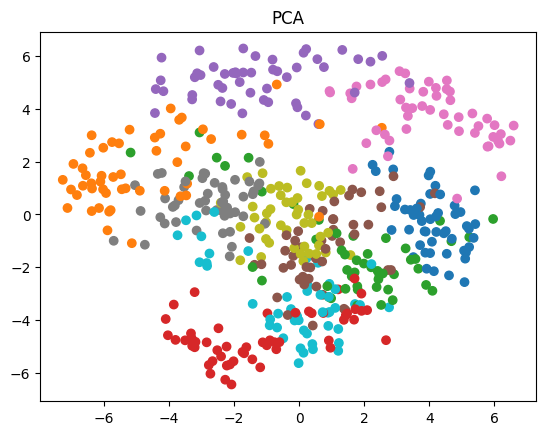

get affinity matrix
run t-SNE
  0 2.220
 50 1.179
100 1.008
150 0.748
200 0.656
250 0.610
300 0.580
350 0.559
400 0.543
450 0.531
500 0.520
550 0.512
600 0.504
650 0.498
700 0.493
750 0.488
800 0.484
850 0.481
900 0.477
950 0.474


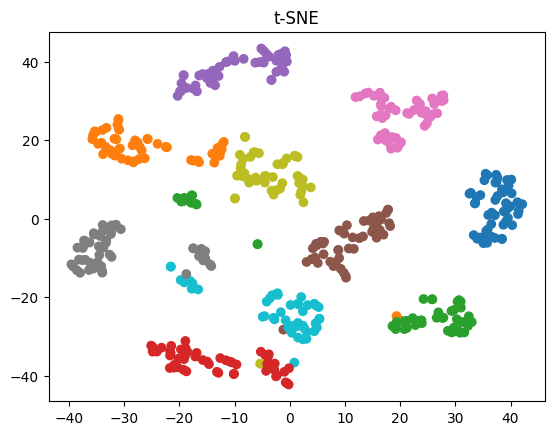

In [11]:
import utils
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# read input dataset
X,color=utils.get_data()

# run PCA
U,W,_ = numpy.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=color,cmap='tab10'); plt.title('PCA')
plt.show()

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X,Y0,10.0,100.0)
plt.scatter(*Y.T,c=color,cmap='tab10'); plt.title('t-SNE')
plt.show()

We observe that the t-SNE embedding better captures the relevant structure of the data, by arranging digits of different classes into distinct clusters.